# Lab - Disease prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

I det här momentet kommer vi jobba med ett dataset med data för hjärt-kärlsjukdom. Börja med att ladda
ned datasetet från Kaggle och läs på vad de olika features betyder. Notera att detta dataset innehåller
många felaktigheter, exempelvis finns negativa blodtryck och blodtryck som är omöjligt höga.

Data description
There are 3 types of input features:

Objective: factual information; \
Examination: results of medical examination; \
Subjective: information given by the patient. \
Features: 

Age | Objective Feature | age | int (days) \
Height | Objective Feature | height | int (cm) | \
Weight | Objective Feature | weight | float (kg) | \
Gender | Objective Feature | gender | categorical code | 1: women, 2: men\
Systolic blood pressure | Examination Feature | ap_hi | int | \
Diastolic blood pressure | Examination Feature | ap_lo | int | \
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal | \
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal | \
Smoking | Subjective Feature | smoke | binary | \
Alcohol intake | Subjective Feature | alco | binary | \
Physical activity | Subjective Feature | active | binary | \
Presence or absence of cardiovascular disease | Target Variable | cardio | binary | \
All of the dataset values were collected at the moment of medical examination. 

However, there is no information about what the values of the binary variables represent. I will assume that 0 means not present/no and 1 means present/yes.

In [2]:
df_cardio = pd.read_csv("Data/cardio_train.csv", sep=";")
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [3]:
df_cardio.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_cardio.info() # No missig values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### 2.0 - EDA uppvärmning

Använd pandas, matplotlib och seaborn för att besvara på följande frågor för datasetet:
a) Hur många är positiva för hjärt-kärlsjukdom och hur många är negativa?

In [5]:
cardio_count = df_cardio["cardio"].value_counts().to_frame()

print(f"Number of positive cases for cardiovascular disease: {cardio_count['cardio'].iloc[1]}")
print(f"Number of negative cases for cardiovascular disease: {cardio_count['cardio'].iloc[0]}")

Number of positive cases for cardiovascular disease: 34979
Number of negative cases for cardiovascular disease: 35021


b) Hur stor andel har normala, över normala och långt över normala kolesterolvärden? Rita ett tårtdiagram.

In [6]:
cholesterol_count = df_cardio["cholesterol"].value_counts().to_frame()
cholesterol_count

,cholesterol
1,52385
2,9549
3,8066


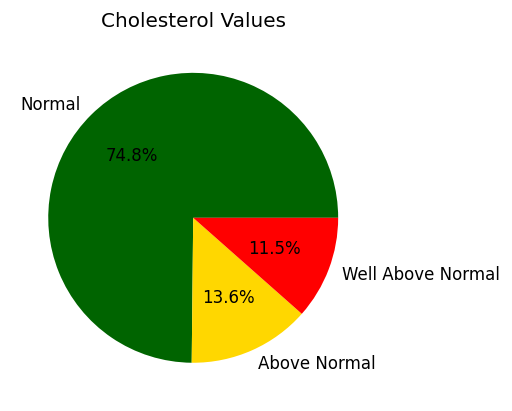

In [7]:
fig, ax = plt.subplots(dpi=120, facecolor="white")
plt.pie(cholesterol_count["cholesterol"], 
            labels=["Normal", "Above Normal", "Well Above Normal"], 
            colors=["darkgreen", "gold", "red"],
            autopct="%1.1f%%")
_ = ax.set_title("Cholesterol Values")

c) Hur ser åldersfördelningen ut? Rita ett histogram.

In [8]:
ages = pd.DataFrame({"Age": df_cardio["age"]/365})
ages

,Age
0,50.391781
1,55.419178
2,51.663014
3,48.282192
4,47.873973
...,...
69995,52.712329
69996,61.920548
69997,52.235616
69998,61.454795


In [9]:
ages.min(), ages.max()

(Age    29.583562
 dtype: float64,
 Age    64.967123
 dtype: float64)

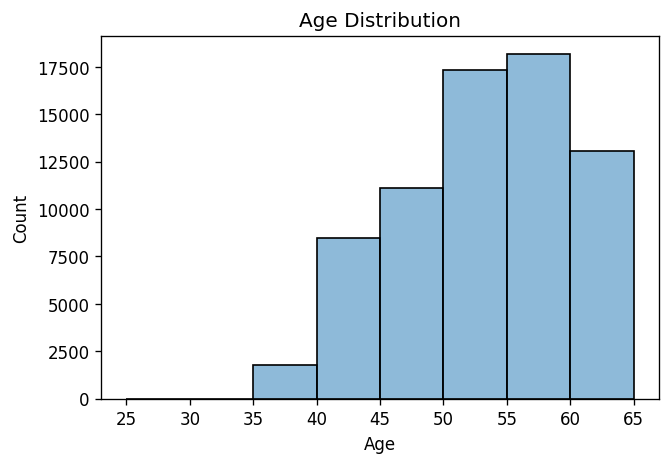

In [10]:
fig = plt.figure(dpi=120)
ax = sns.histplot(ages, bins=range(25, 70, 5), legend=False)
_ = ax.set(title="Age Distribution", xlabel="Age")

d) Hur stor andel röker?

In [11]:
print(f"{df_cardio['smoke'].sum()/len(df_cardio)*100:.1f}% of the participants smoke.")

8.8% of the participants smoke.


e) Hur ser viktfördelningen ut? Rita lämpligt diagram.

In [12]:
df_cardio["weight"].min(), df_cardio["weight"].max()

(10.0, 200.0)

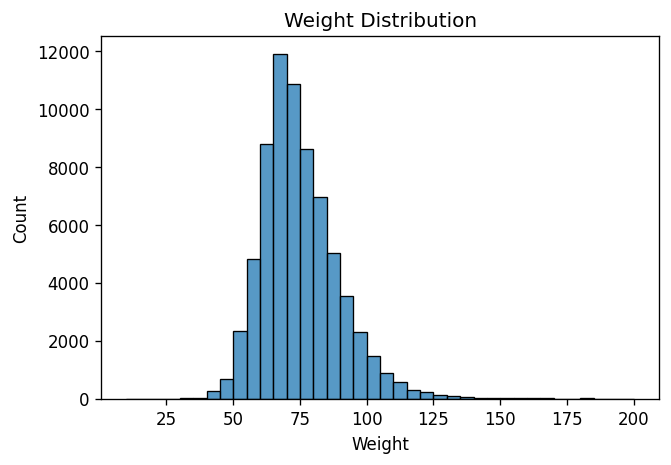

In [13]:
fig = plt.figure(dpi=120)
ax = sns.histplot(df_cardio["weight"], bins=range(10, 205, 5), legend=False)
_ = ax.set(title="Weight Distribution", xlabel="Weight")

f) Hur ser längdfördelningen ut? Rita lämpligt diagram.

In [14]:
df_cardio["height"].min(), df_cardio["height"].max()

(55, 250)

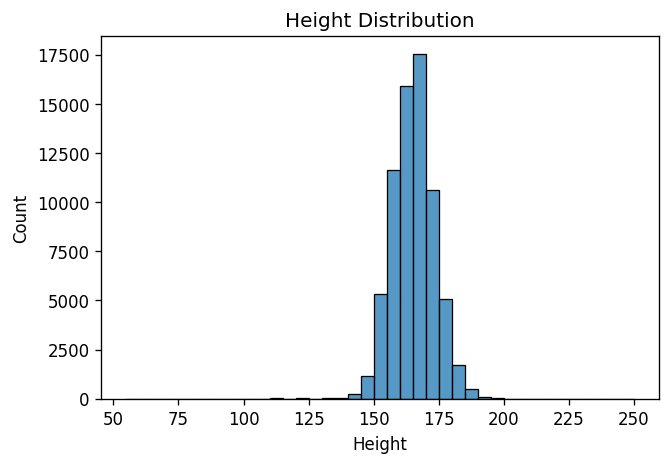

In [15]:
fig = plt.figure(dpi=120)
ax = sns.histplot(df_cardio["height"], bins=range(55, 255, 5))
_ = ax.set(title="Height Distribution", xlabel="Height")

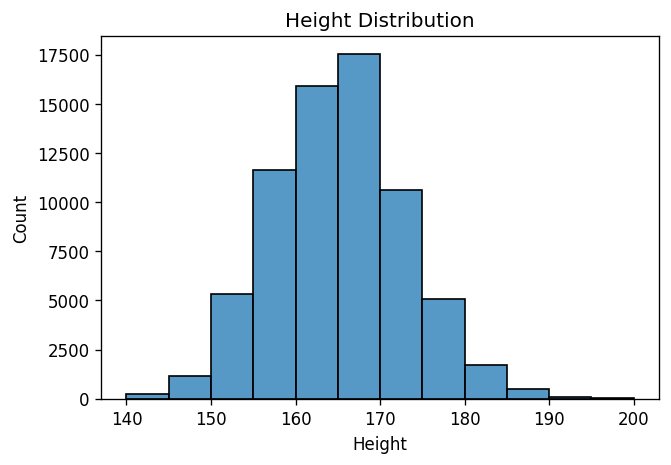

In [16]:
fig = plt.figure(dpi=120)
ax = sns.histplot(df_cardio["height"], bins=range(140, 205, 5))
_ = ax.set(title="Height Distribution", xlabel="Height")

g) Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom? Rita lämpligt diagram

There is no information in the data about which gender is coded as 1 and which is coded as 2. Gender is not balanced.

In [17]:
cardio_gender = pd.DataFrame({"cardio":df_cardio["cardio"].groupby(df_cardio["gender"]).sum(), 
                            "gender":df_cardio["gender"].value_counts()})
cardio_gender["%"] = (cardio_gender["cardio"] / cardio_gender["gender"] * 100).round(2)
cardio_gender

,cardio,gender,%
1,22616,45530,49.67
2,12363,24470,50.52


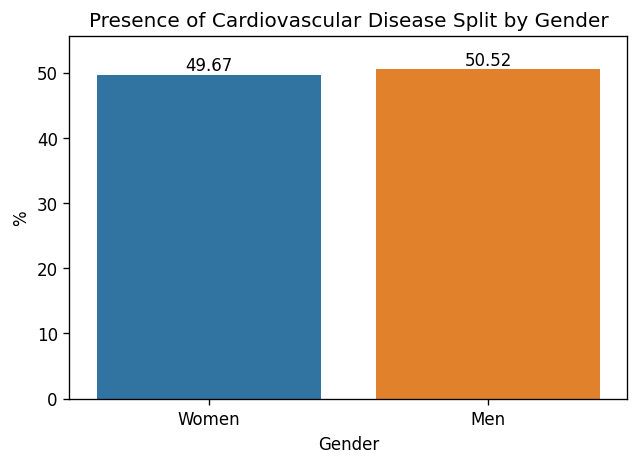

In [18]:
fig = plt.figure(dpi=120)
ax = sns.barplot(data=cardio_gender, x=["Women", "Men"], y="%")
ax.set(xlabel="Gender", title="Presence of Cardiovascular Disease Split by Gender")
ax.bar_label(ax.containers[0])
ax.margins(y=0.1)

### 2.1.0 - Feature engineering BMI
Skapa en feature för BMI (Body Mass Index), läs på om formeln på wikipedia.

a) Släng de samples med orimliga BMIer och outliers. Notera att detta kan vara svårt att avgöra i vilket
range av BMIer som vi ska spara. Beskriv hur du gör avvägningen.

In [19]:
df_cardio["BMI"] = df_cardio["weight"] / ((df_cardio["height"]/100)**2)
df_cardio["BMI"]

0        21.967120
1        34.927679
2        23.507805
3        28.710479
4        23.011177
           ...    
69995    26.927438
69996    50.472681
69997    31.353579
69998    27.099251
69999    24.913495
Name: BMI, Length: 70000, dtype: float64

In [20]:
df_cardio["BMI"].min(), df_cardio["BMI"].max()

(3.471783865673526, 298.6666666666667)

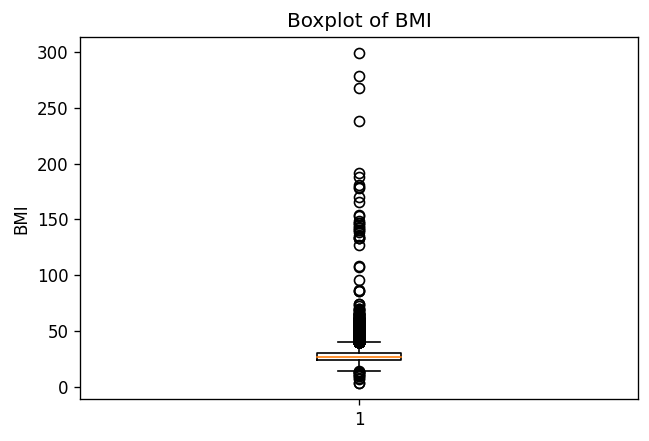

In [21]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["BMI"]);
ax.set_title("Boxplot of BMI")
ax.set_ylabel("BMI");

As can be seen above, the BMI data is extremeley skewed. We have some values very close to 0 and some extremely high values. Some of these values are not possible, for example a BMI of 3.47 or a BMI of 298.7, i.e. the minimum and the maxmum values. Since the data is skewed we should not use z-values for outlier detection. Instead we can use interquartile rule to detect outliers. Calculating outliers this way is not affected to any larger extent by the extreme/impossible high values (as the z-values would) and there is no real need to remove them before the computation. 

In [22]:
def outlier_cut_off(data:pd.Series):
    quant25= np.percentile(data, q=25)
    quant75= np.percentile(data, q=75)
    iqr = stats.iqr(data)

    outlier_low = quant25 - 1.5*iqr
    outlier_high = quant75 + 1.5*iqr

    return outlier_low, outlier_high

In [23]:
outlier_low_bmi, outlier_high_bmi = outlier_cut_off(df_cardio["BMI"])
print(outlier_low_bmi, outlier_high_bmi)

14.354453627180908 39.74288337924701


A bit interesting is that there are more observations exactly equal to the first quartile than the third quartile, as can be seen below. This leads to that the quartiles do not have the same size. 

In [24]:
bmi_quant25= np.percentile(df_cardio["BMI"], q=25)
bmi_quant75= np.percentile(df_cardio["BMI"], q=75)

print(f"Observations in first quartile: {len(df_cardio[df_cardio['BMI'] < bmi_quant25])}")
print(f"Observations in forth quartile: {len(df_cardio[df_cardio['BMI'] > bmi_quant75])}")

print(f"Number of observations exactly equal to the first quantile value: {len(df_cardio[df_cardio['BMI'] == bmi_quant25])}")
print(f"Number of observations exactly equal to the third quantile value: {len(df_cardio[df_cardio['BMI'] == bmi_quant75])}")

values_first_quantile = df_cardio[df_cardio["BMI"] == bmi_quant25]
print(f"There is {values_first_quantile['height'].nunique()} unique value for height and {values_first_quantile['weight'].nunique()} unique value for weight.")
print(f"There is {len(df_cardio[df_cardio['BMI'] == bmi_quant25])} people with a height of {values_first_quantile['height'].iloc[0]} and a weight of {values_first_quantile['weight'].iloc[0]}.")

Observations in first quartile: 17194
Observations in forth quartile: 17483
Number of observations exactly equal to the first quantile value: 943
Number of observations exactly equal to the third quantile value: 29
There is 1 unique value for height and 1 unique value for weight.
There is 943 people with a height of 165 and a weight of 65.0.


If we were to classify an outlier as being a person with a BMI above 39.7 (as calculated by the IQR), we will not be able to classify any observations to obesity class 3. Some previous studies have suggested an even higher obesity category, that is obesity class 4, which is defined as having a BMI above 50. Based on this theory, I therefore decide to classify outliers as people with a BMI above 50. The lower value for outliers, 14.4, seems reasonable.

In [25]:
print(f"There are {len(df_cardio[(df_cardio['BMI'] > 40) & (df_cardio['BMI'] < 50)])} observations with a BMI between 40 and 50.")

There are 1628 observations with a BMI between 40 and 50.


In [26]:
df_cardio = df_cardio[(df_cardio["BMI"] >= outlier_low_bmi ) & (df_cardio["BMI"] < 50)] 
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


In [27]:
print(f"Minimum BMI: {df_cardio['BMI'].min():.1f}, Maximum BMI: {df_cardio['BMI'].max():.1f}")
print(f"Minimum height: {df_cardio['height'].min()} cm, Maximum height: {df_cardio['height'].max():.0f} cm")
print(f"Minimum weight: {df_cardio['weight'].min():.0f} kg, Maximum weight: {df_cardio['weight'].max():.0f} kg")

Minimum BMI: 14.5, Maximum BMI: 50.0
Minimum height: 98 cm, Maximum height: 207 cm
Minimum weight: 28 kg, Maximum weight: 180 kg


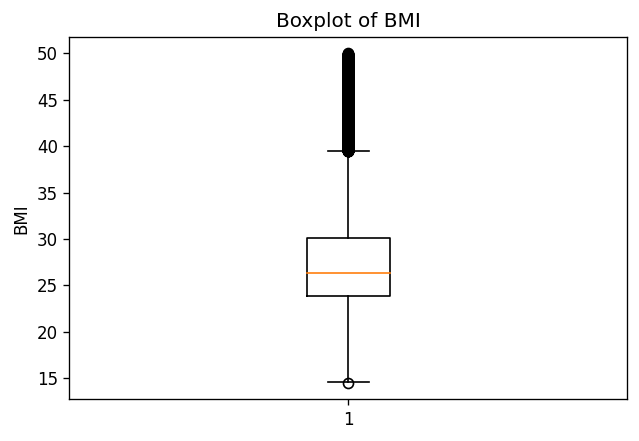

In [28]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["BMI"]);
ax.set_title("Boxplot of BMI")
ax.set_ylabel("BMI");

The shortest person is 98 cm. However, since dwarfism is a risk factor for cardiovascular disease, I choose to keep this value. If I were to remove it, I would not be able to get good predictions for cardiovascular disease for similar heights.

b) Skapa en kategorisk BMI-feature med kategorierna: normal range, overweight, obese (class I), obese
(class II), obese (class III).

Since a low BMI is also a risk factor for cardiovascular diseace, I also choose to create categories for lower body weights. 

In [29]:
# Reference: https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable
df_cardio=df_cardio.assign(BMI_category=np.nan)
df_cardio.loc[(df_cardio["BMI"] < 18.5), "BMI_category"] = "under_weight"
df_cardio.loc[(df_cardio["BMI"] >= 18.5) & (df_cardio["BMI"] <= 25), "BMI_category"] = "normal_weight"
df_cardio.loc[(df_cardio["BMI"] > 25) & (df_cardio["BMI"] <= 30), "BMI_category"] = "over_weight"
df_cardio.loc[(df_cardio["BMI"] > 30) & (df_cardio["BMI"] <= 35), "BMI_category"] = "obesity_class1"
df_cardio.loc[(df_cardio["BMI"] > 35) & (df_cardio["BMI"] <= 40), "BMI_category"] = "obesity_class2"
df_cardio.loc[(df_cardio["BMI"] > 40), "BMI_category"] = "obesity_class3"

### 2.1.1 - Feature engineering blodtryck
Släng bort samples med orimliga blodtryck och outliers. Likt uppgift 2.1.0 är det inte trivialt att sätta
gränserna. Skapa en feature för blodtryckskategorier enligt tabellen i denna artikel.

As we can see by the boxplots below we have some extremely high and unrealistic blood pressures, which we need to remove. 

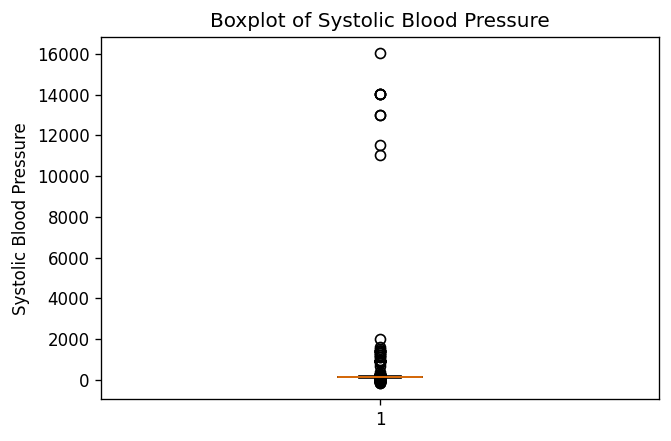

In [30]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["ap_hi"]);
ax.set_title("Boxplot of Systolic Blood Pressure")
ax.set_ylabel("Systolic Blood Pressure");

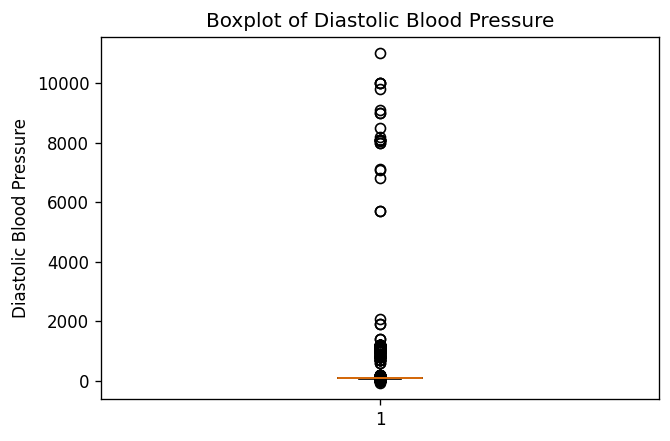

In [31]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["ap_lo"]);
ax.set_title("Boxplot of Diastolic Blood Pressure")
ax.set_ylabel("Diastolic Blood Pressure");

We also have negative values. 

In [32]:
print(f"Minimum Systolic Blood Pressure: {df_cardio['ap_hi'].min()}, Maximum Systolic Blood Pressure: {df_cardio['ap_hi'].max()}")
print(f"Minimum Diastolic Blood Pressure: {df_cardio['ap_lo'].min()}, Maximum Diastolic Blood Pressure: {df_cardio['ap_hi'].max()}") 

Minimum Systolic Blood Pressure: -150, Maximum Systolic Blood Pressure: 16020
Minimum Diastolic Blood Pressure: -70, Maximum Diastolic Blood Pressure: 16020


In [33]:
outlier_low_ap_hi, outlier_high_ap_hi = outlier_cut_off(df_cardio["ap_hi"])
print(outlier_low_ap_hi, outlier_high_ap_hi)

90.0 170.0


In [34]:
ap_hi_quant25= np.percentile(df_cardio["ap_hi"], q=25)
ap_hi_quant75= np.percentile(df_cardio["ap_hi"], q=75)

print(f"Number of observations exactly equal to the first quantile value: {len(df_cardio[df_cardio['ap_hi'] == ap_hi_quant25])}")
print(f"Number of observations exactly equal to the third quantile value: {len(df_cardio[df_cardio['ap_hi'] == ap_hi_quant75])}")
print(f"There are {len(df_cardio[df_cardio['ap_hi'] < 90])} people with a systolic blood pressure below 90.")
print(f"There are {len(df_cardio[df_cardio['ap_hi'] > 170])} people with a systolic blood pressure above 170.")

Number of observations exactly equal to the first quantile value: 27621
Number of observations exactly equal to the third quantile value: 9460
There are 320 people with a systolic blood pressure below 90.
There are 1097 people with a systolic blood pressure above 170.


For systolic blood pressure we have many extreme and unrealistic values (for example 38 observations with values above 700, see below).

According to the results above for outlier detection (again based on IQR since data is skewed), we should not include systolic blood pressures below 90 or above 170. 

A hypertensive crisis is classified as having a systolic blood pressure of above 180 (and/or a diastolic bloodpressure over 120). It is not realistic to take part in a study if your blood pressure is so high that you need immediate hosipital care. However, since I do not know how the data was collected (parts of it could be collected at the hospital) and since I would also like to categorise people to the hypertensive group, I would like to have a somewhat higher cut off. Based on the results below, it seems reasonable to construct a group for people with systolic blood pressures between 180 and 220 (outliers would therefore be blood pressures > 220). This also seems reasonable, based on earlier research (https://pubmed.ncbi.nlm.nih.gov/14689106/). 

In [35]:
for i in range(180, 260, 10):
    print(f"There are {len(df_cardio[df_cardio['ap_hi'] > i])} people with a systolic blood pressure above {i}.")

print(f"\nThere are {len(df_cardio[df_cardio['ap_hi'] > 700])} people with a systolic blood pressure above 700")

There are 362 people with a systolic blood pressure above 180.
There are 214 people with a systolic blood pressure above 190.
There are 99 people with a systolic blood pressure above 200.
There are 73 people with a systolic blood pressure above 210.
There are 48 people with a systolic blood pressure above 220.
There are 47 people with a systolic blood pressure above 230.
There are 40 people with a systolic blood pressure above 240.
There are 40 people with a systolic blood pressure above 250.

There are 38 people with a systolic blood pressure above 700


I continue checking the diastolic blood pressure. According to the IQR (see below), values below 65 and above 105 should be considered outliers. Again, since I would like to be able to classify people to the hypertensive group, I would like to have a higher cut-off.

In [36]:
outlier_low_ap_lo, outlier_high_ap_lo = outlier_cut_off(df_cardio["ap_lo"])
print(outlier_low_ap_lo, outlier_high_ap_lo)

65.0 105.0


In [37]:
ap_lo_quant25= np.percentile(df_cardio["ap_lo"], q=25)
ap_lo_quant75= np.percentile(df_cardio["ap_lo"], q=75)

print(f"Number of observations exactly equal to the first quantile value: {len(df_cardio[df_cardio['ap_lo'] == ap_lo_quant25])}")
print(f"Number of observations exactly equal to the third quantile value: {len(df_cardio[df_cardio['ap_lo'] == ap_lo_quant75])}")
print(f"There are {len(df_cardio[df_cardio['ap_lo'] < 65])} people with a diastolic blood pressure below 65.")
print(f"There are {len(df_cardio[df_cardio['ap_lo'] > 105])} people with a diastolic blood pressure above 105.")

Number of observations exactly equal to the first quantile value: 34744
Number of observations exactly equal to the third quantile value: 14243
There are 2925 people with a diastolic blood pressure below 65.
There are 1681 people with a diastolic blood pressure above 105.


There is quite many observations with values below 65 for the diastolic blood pressure (see above). Looking at the results below 60 would probably be a better cut off. We do not want to remove too many observations. 

In [38]:
for i in range(0, 80, 10):
    print(f" There are {len(df_cardio[df_cardio['ap_lo'] < i])} people with a diastolic blood pressure below {i}.")

 There are 1 people with a diastolic blood pressure below 0.
 There are 29 people with a diastolic blood pressure below 10.
 There are 37 people with a diastolic blood pressure below 20.
 There are 52 people with a diastolic blood pressure below 30.
 There are 58 people with a diastolic blood pressure below 40.
 There are 79 people with a diastolic blood pressure below 50.
 There are 174 people with a diastolic blood pressure below 60.
 There are 3146 people with a diastolic blood pressure below 70.


I continue with examining the number of people with diastolic blood pressures above a certain value. From this it seems reasonable to choose a cut off of 140, since the values after that drops very slowly. This includes some people in the hypertensic group. 

In [39]:
for i in range(105, 165, 5):
    print(f"There are {len(df_cardio[df_cardio['ap_lo'] > i])} people with a diastolic blood pressure above {i}.")
print(f"\nThere are {len(df_cardio[df_cardio['ap_lo'] > 900])} people with a diastolic blood pressure above 900.")

There are 1681 people with a diastolic blood pressure above 105.
There are 1267 people with a diastolic blood pressure above 110.
There are 1251 people with a diastolic blood pressure above 115.
There are 1046 people with a diastolic blood pressure above 120.
There are 1042 people with a diastolic blood pressure above 125.
There are 1006 people with a diastolic blood pressure above 130.
There are 1005 people with a diastolic blood pressure above 135.
There are 975 people with a diastolic blood pressure above 140.
There are 975 people with a diastolic blood pressure above 145.
There are 967 people with a diastolic blood pressure above 150.
There are 967 people with a diastolic blood pressure above 155.
There are 958 people with a diastolic blood pressure above 160.

There are 917 people with a diastolic blood pressure above 900.


Somewhere in the process of identifying outliers I started to suspect that this data is not real. Below I have printed the value counts for all of the diastolic blood pressures between 100 and 140, and it is very clear that every tenth value is highly overrepresented. This makes it difficult to work with the data. 

In [40]:
values_100_140 = df_cardio[(df_cardio["ap_lo"] >= 100) & (df_cardio["ap_lo"] < 140)]
pd.DataFrame(values_100_140["ap_lo"].value_counts())

,ap_lo
100,4052
110,397
120,202
130,34
105,19
115,8
109,7
103,6
106,6
101,5


I have thus chosen the following range of values: 

Systolic: 90-220 (both values included)\
Diastolic: 60-140 (both values included)

In [41]:
df_cardio = df_cardio[(df_cardio["ap_hi"] >= 90 ) & (df_cardio["ap_hi"] <= 220) 
                    & (df_cardio["ap_lo"] >= 60 ) & (df_cardio["ap_lo"] <= 140)]
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,normal_weight
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,obesity_class1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,normal_weight
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,over_weight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,normal_weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,over_weight
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,over_weight
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,obesity_class1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,over_weight


It is not possible for the diastolic blood pressure to be higher than the systolic blood pressure, and I therefore continue removing theses cases. 

In [42]:
print(f"In {len(df_cardio[df_cardio['ap_lo'] >= df_cardio['ap_hi']])} cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.")

In 26 cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.


In [43]:
df_cardio[df_cardio['ap_lo'] >= df_cardio['ap_hi']].head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
4825,6836,19618,2,164,89.0,90,140,2,2,0,0,1,1,33.090422,obesity_class1
5121,7277,17600,2,173,78.0,90,140,1,1,0,1,1,1,26.061679,over_weight
5446,7737,18968,1,165,110.0,95,130,1,1,0,1,1,1,40.404040,obesity_class3
9010,12847,20400,2,176,82.0,90,130,3,3,0,0,1,1,26.472107,over_weight
10748,15369,20743,2,170,77.0,90,130,1,1,0,0,0,0,26.643599,over_weight


In [44]:
df_cardio = df_cardio[df_cardio['ap_lo'] < df_cardio['ap_hi']]
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,normal_weight
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,obesity_class1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,normal_weight
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,over_weight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,normal_weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,over_weight
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,over_weight
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,obesity_class1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,over_weight


In [45]:
print(f"Minimum Systolic Blood Pressure: {df_cardio['ap_hi'].min()}, Maximum Systolic Blood Pressure: {df_cardio['ap_hi'].max()}")
print(f"Minimum Diastolic Blood Pressure: {df_cardio['ap_lo'].min()}, Maximum Diastolic Blood Pressure: {df_cardio['ap_lo'].max()}") 
print(f"In {len(df_cardio[df_cardio['ap_lo'] >= df_cardio['ap_hi']])} cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.")

Minimum Systolic Blood Pressure: 90, Maximum Systolic Blood Pressure: 220
Minimum Diastolic Blood Pressure: 60, Maximum Diastolic Blood Pressure: 140
In 0 cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.


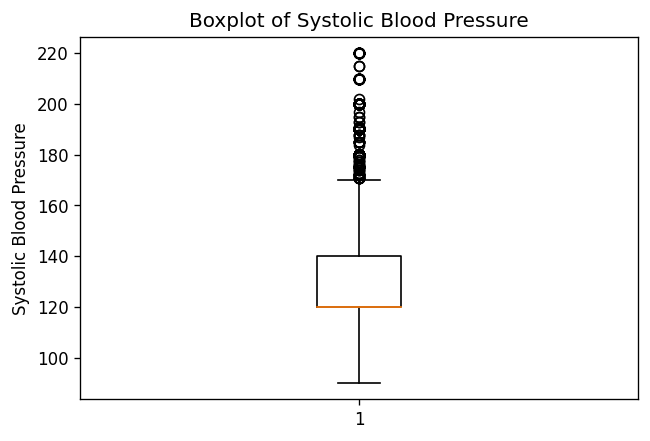

In [46]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["ap_hi"]);
ax.set_title("Boxplot of Systolic Blood Pressure")
ax.set_ylabel("Systolic Blood Pressure");

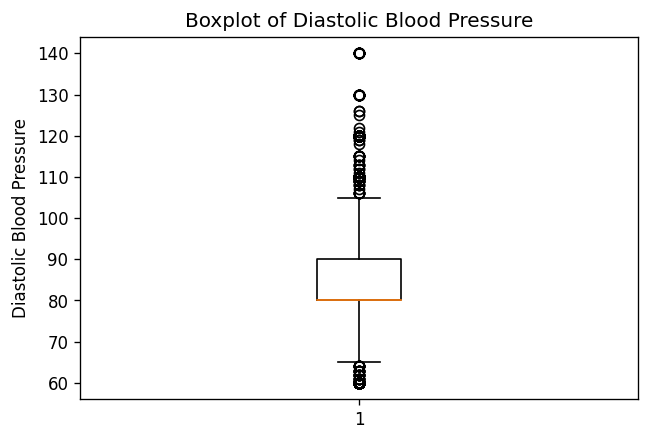

In [47]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["ap_lo"]);
ax.set_title("Boxplot of Diastolic Blood Pressure")
ax.set_ylabel("Diastolic Blood Pressure");

In [56]:
# Reference: https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable
df_cardio=df_cardio.assign(BP_category=np.nan)
df_cardio.loc[(df_cardio["ap_hi"] < 120) & (df_cardio["ap_lo"] < 80), 
            "BP_category"] = "healthy"
df_cardio.loc[(df_cardio["ap_hi"] >= 120) & (df_cardio["ap_hi"] < 130) 
            & (df_cardio["ap_lo"] < 80), 
            "BP_category"] = "elevated"
df_cardio.loc[((df_cardio["ap_hi"] >= 130) & (df_cardio["ap_hi"] < 140)) 
            | ((df_cardio["ap_lo"] >= 80) & (df_cardio["ap_lo"] < 90)), 
            "BP_category"] = "hypertension_stage1"
df_cardio.loc[((df_cardio["ap_hi"] >= 140) & (df_cardio["ap_hi"] <= 180)) 
            | ((df_cardio["ap_lo"] >= 90) & (df_cardio["ap_lo"] <= 120)), 
            "BP_category"] = "hypertension_stage2"
df_cardio.loc[(df_cardio["ap_hi"] > 180) | (df_cardio["ap_lo"] > 120), 
            "BP_category"] = "hypertension_crisis"


In [57]:
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category,BP_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,normal_weight,hypertension_stage1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,obesity_class1,hypertension_stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,normal_weight,hypertension_stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,over_weight,hypertension_stage2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,normal_weight,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,over_weight,hypertension_stage2
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,over_weight,hypertension_stage1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,obesity_class1,hypertension_stage2
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,over_weight,hypertension_stage1


In [59]:
df_cardio["BP_category"].value_counts()

hypertension_stage1    32359
hypertension_stage2    23107
healthy                 9398
elevated                3096
hypertension_crisis      275
Name: BP_category, dtype: int64

### 2.2.0 - Visualiseringar andel sjukdomar
Skapa barplots med en feature mot andelen positiva för hjärt-kärlsjukdom. Exempelvis blodtryckskategorier
mot andel positiva, BMI kategori mot andel positiva mm. Gör dessa plots i en figur med flera subplots.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5728753/ 